# ----- Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import inflect
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re, string, unicodedata
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob, Word
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import langid

warnings.filterwarnings('ignore')

# ----- Import Data

In [2]:
# Import dataset
df = pd.read_csv('Coursera_reviews.csv')
raw = df.copy()

# view sample of dataset
raw.head()


reviews       reviewers  \
0  Pretty dry, but I was able to pass with just t...     By Robert S   
1  would be a better experience if the video and ...  By Gabriel E R   
2  Information was perfect! The program itself wa...      By Jacob D   
3  A few grammatical mistakes on test made me do ...       By Dale B   
4  Excellent course and the training provided was...       By Sean G   

   date_reviews  rating                 course_id  
0  Feb 12, 2020       4  google-cbrs-cpi-training  
1  Sep 28, 2020       4  google-cbrs-cpi-training  
2  Apr 08, 2020       4  google-cbrs-cpi-training  
3  Feb 24, 2020       4  google-cbrs-cpi-training  
4  Jun 18, 2020       4  google-cbrs-cpi-training

In [5]:
lst = ['python','python-data','python-data-analysis']
temp = raw[raw['course_id'].isin(lst)]
temp_count = pd.pivot_table(temp, index=['course_id'],aggfunc={'reviews': 'count'}).reset_index().sort_values(by=['reviews'], ascending=False)

temp_count

course_id  reviews
0                python    45218
1           python-data    33543
2  python-data-analysis    14289

# ----- Data Preprocessing

In [13]:
# Check dataset info
print(raw.info())

# Check null value
print(raw.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1454711 entries, 0 to 1454710
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   reviews       1454571 non-null  object
 1   reviewers     1454711 non-null  object
 2   date_reviews  1454711 non-null  object
 3   rating        1454711 non-null  int64 
 4   course_id     1454711 non-null  object
dtypes: int64(1), object(4)
memory usage: 55.5+ MB
None
reviews         140
reviewers         0
date_reviews      0
rating            0
course_id         0
dtype: int64


In [14]:
# Remove duplicates reviews by same person
raw = raw.drop_duplicates(subset=['reviews', 'reviewers','course_id'], keep='last')

# Select useful columns only
raw = raw[['course_id','reviews','rating']]

# Get rviews length
raw["reviews_length"]= raw["reviews"].str.len() 

# Filter reviews with length > 2 only
raw = raw[raw['reviews_length']>2]

# Check dataset info
print(raw.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 517271 entries, 0 to 1454697
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   course_id       517271 non-null  object 
 1   reviews         517271 non-null  object 
 2   rating          517271 non-null  int64  
 3   reviews_length  517271 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 19.7+ MB
None


# ----- Exploratory Data Analysis

In [15]:
eda = raw.copy()

In [16]:
# Get number of reviews per course_id
review_count = pd.pivot_table(eda, index=['course_id'],aggfunc={'reviews': 'count'}).reset_index().sort_values(by=['reviews'], ascending=False)
review_count.head(10)

course_id  reviews
446                          python    15183
344                machine-learning    12665
388   neural-networks-deep-learning    12288
532  technical-support-fundamentals    12042
339           learning-how-to-learn    11851
449                     python-data    11404
538       the-science-of-well-being     8169
595             what-is-datascience     7360
187                excel-essentials     7340
9                   ai-for-everyone     7305

Text(0, 0.5, 'Density')

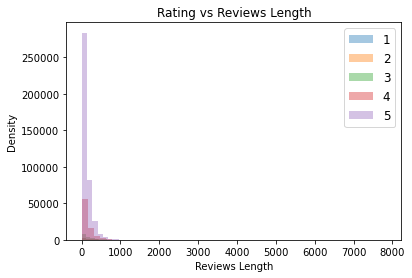

In [17]:
for i in [1,2,3,4,5]:
    df = eda[eda.rating == i]
    sns.distplot(df['reviews_length'],  kde=False, label=i)


# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Rating vs Reviews Length')
plt.xlabel('Reviews Length')
plt.ylabel('Density')

# ----- Data Collection

In [51]:
def check_language(string):
    return langid.classify(string)[0]

df = raw.copy()

# Select three popular Python courses for further analysis
lst = ['python','python-data','python-data-analysis']
df = df[df['course_id'].isin(lst)]

# Detect reviews language
df['language'] = df['reviews'].apply(check_language)

# Select English reviews only
df = df[df['language']=='en']

course_id                                            reviews  rating  \
15777      python  I did not find this course helpful. The assign...       1   
15778      python  I got a 95% and maybe I learned something but ...       1   
15779      python  Two weeks of all sort of nonsense, including m...       1   
15780      python  We tried to use this class to teach a brown ba...       1   
15781      python  To be honest, I thought the course stumbled an...       1   
...           ...                                                ...     ...   
1454194    python  This course is so good. I can easily understan...       5   
1454197    python  Excellent and in-depth explanation of each and...       5   
1454202    python  Love it! Even though it isn't my first python ...       5   
1454203    python  Really good introduction to python! This progr...       5   
1454206    python  This is my first coursera course which i have ...       5   

         reviews_length language  
15777             476.0       en  
15778             376.0       en  
15779             375.0       en  
15780             335.0       en  
15781            1328.0       en  
...                 ...      ...  
1454194            93.0       en  
1454197            93.0       en  
1454202            92.0       en  
1454203            92.0       en  
1454206            92.0       en  

[31474 rows x 5 columns]

In [52]:
df.to_csv('python_only.csv',index=False)

In [2]:
df = pd.read_csv('python_only.csv')
df = df[df['language']=='en']

# ----- EDA of Python Courses only

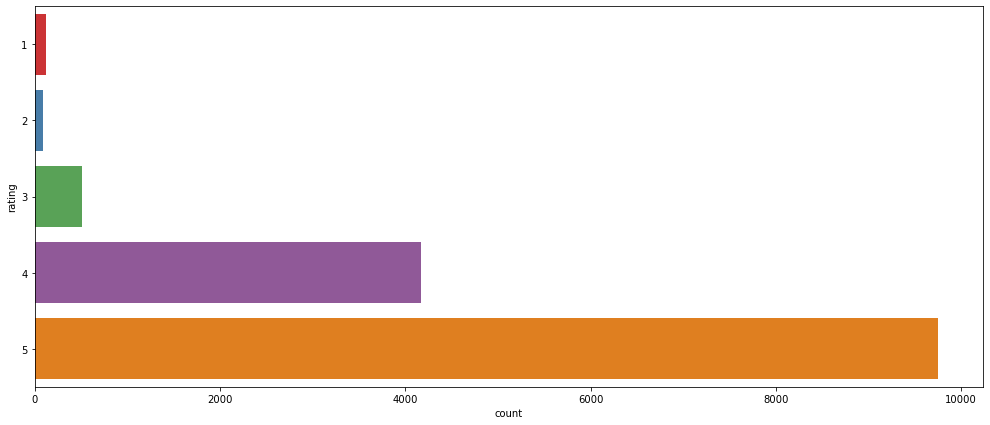

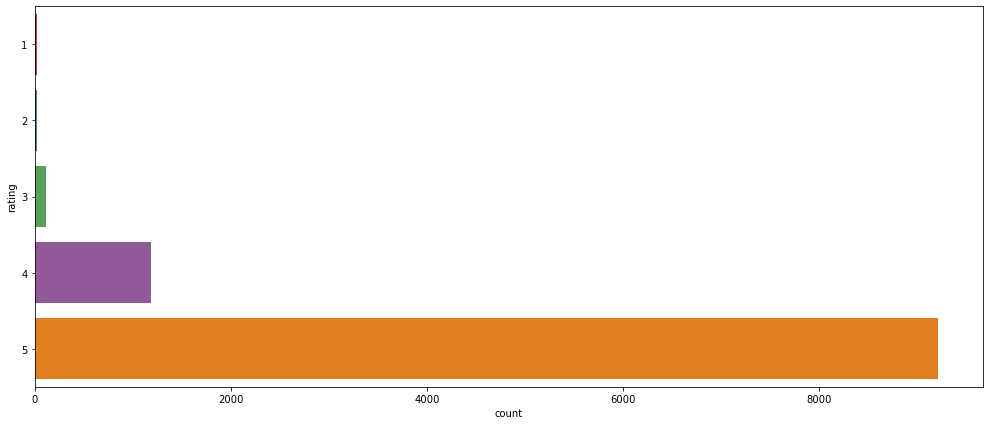

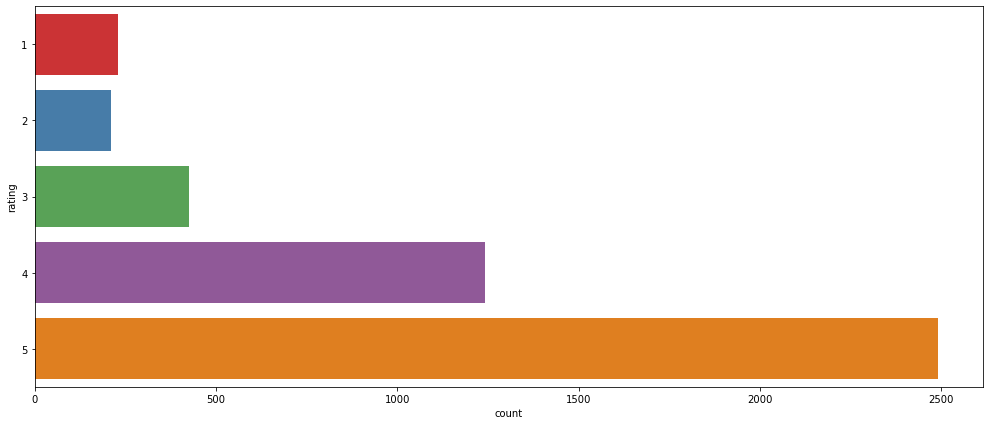

In [206]:
# Bar Chart
lst = ['python','python-data','python-data-analysis']
for i in lst:
    plt.figure(figsize=(17,7))
    sns.countplot(y='rating',data=df[df['course_id']==i],palette='Set1')


In [207]:
df.groupby('course_id').describe().unstack(1)

                       course_id           
rating          count  python                  14642.000000
                       python-data             10571.000000
                       python-data-analysis     4601.000000
                mean   python                      4.592405
                       python-data                 4.848453
                       python-data-analysis        4.206477
                std    python                      0.673007
                       python-data                 0.440523
                       python-data-analysis        1.107666
                min    python                      1.000000
                       python-data                 1.000000
                       python-data-analysis        1.000000
                25%    python                      4.000000
                       python-data                 5.000000
                       python-data-analysis        4.000000
                50%    python                      5.000

In [3]:
df.groupby('rating').describe().unstack(1)

                       rating
reviews_length  count  1           384.000000
                       2           328.000000
                       3          1051.000000
                       4          6599.000000
                       5         21452.000000
                mean   1           307.515625
                       2           340.759146
                       3           171.922931
                       4           110.426580
                       5           143.742914
                std    1           457.002916
                       2           443.337688
                       3           245.203598
                       4           140.543208
                       5           135.911374
                min    1             3.000000
                       2             4.000000
                       3             3.000000
                       4             3.000000
                       5             3.000000
                25%    1            47.750000
    

<AxesSubplot:xlabel='reviews_length', ylabel='rating'>

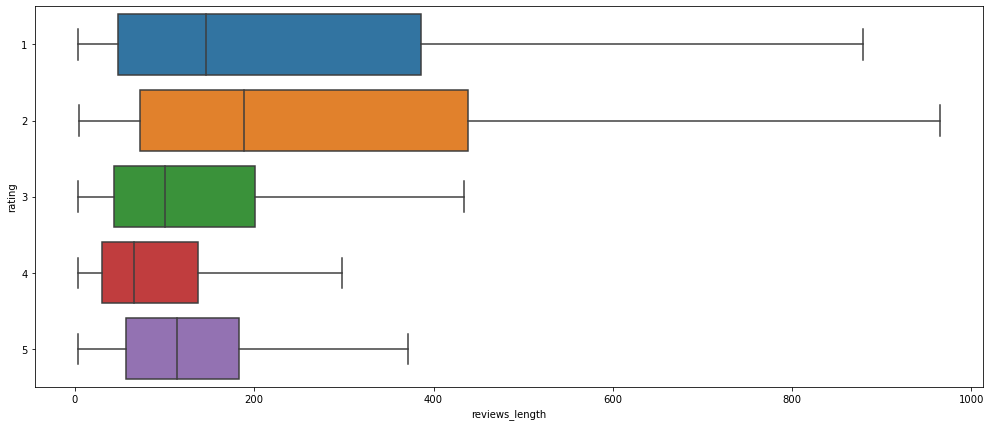

In [5]:
plt.figure(figsize=(17,7))
sns.boxplot(y="rating", x="reviews_length", data=df, orient="h",showfliers = False)

Text(0, 0.5, 'Density')

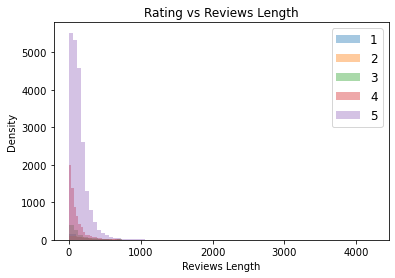

In [210]:
for i in [1,2,3,4,5]:
    d = df[df.rating == i]
    sns.distplot(d['reviews_length'],  kde=False, label=i)


# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Rating vs Reviews Length')
plt.xlabel('Reviews Length')
plt.ylabel('Density')

# ----- Text Preprocessing and Normalization

In [211]:
def rate_grade(num):
    if num > 2:
        return 'positive'
    else:
        return 'negative'
        

In [2]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'd've": "he would have",
"he'll": "he shall",
"he'll've": "he shall havee",
"he's": "he has",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has",
"I'd": "I had",
"I'd've": "I would have",
"I'll": "I shall",
"I'll've": "I shall have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had",
"it'd've": "it would have",
"it'll": "it shall",
"it'll've": "it shall have",
"it's": "it has",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had",
"she'd've": "she would have",
"she'll": "she shall",
"she'll've": "she shall have",
"she's": "she has",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that has",
"there'd": "there had",
"there'd've": "there would have",
"there's": "there has",
"they'd": "they had",
"they'd've": "they would have",
"they'll": "they shall",
"they'll've": "they shall have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall",
"what'll've": "what shall have",
"what're": "what are",
"what's": "what has",
"what've": "what have",
"when's": "when has",
"when've": "when have",
"where'd": "where did",
"where's": "where has",
"where've": "where have",
"who'll": "who shall",
"who'll've": "who shall have",
"who's": "who ha",
"who've": "who have",
"why's": "why has",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had",
"you'd've": "you would have",
"you'll": "you shall",
"you'll've": "you shall have",
"you're": "you are",
"you've": "you have"
}

In [7]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    new = "".join(new_words)
    print(new)
    return (new)

def to_lowercase(words):
    """Convert all characters to lowercase from string of text"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    new = "".join(new_words)
    print(new)
    return (new)


def replace_contractions(words):
    """Replace contractions in string of text"""
    new_words = []
    words = words.split()
    for word in words:
        try:
            expand_word = contractions[word]
            new_words.append(expand_word)
        except:
            new_words.append(word)
    new = " ".join(new_words)
    print(new)
    return (new)

def remove_punctuation(words):
    """Remove punctuation from string of text"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    new = "".join(new_words)
    print(new)
    return (new)

def replace_numbers(words):
    """Replace all interger occurrences in string of text with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    new = "".join(new_words)
    print(new)
    return (new)

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    words = words.split()
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    new = " ".join(new_words)
    print(new)
    return (new)

def lemmatize(words):
    sent = TextBlob(words)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    new = " ".join(lemmatized_list)
    print(new)
    return (new)    

def normalize(words):
#     words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = replace_contractions(words)
    words = remove_punctuation(words)
#     words = replace_numbers(words)
    words = lemmatize(words)
    words = remove_stopwords(words)
    return words

def normalize_without_remove_stopwords(words):
#     words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = replace_contractions(words)
    words = remove_punctuation(words)
#     words = replace_numbers(words)
    words = lemmatize(words)
    return words

x = "There is too much time spent on stuff that isn't programming.  It's maddening."
normalize(x)


there is too much time spent on stuff that isn't programming.  it's maddening.
there is too much time spent on stuff that is not programming. it has maddening.
there is too much time spent on stuff that is not programming it has maddening
there be too much time spend on stuff that be not program it have madden
much time spend stuff program madden


'much time spend stuff program madden'

In [214]:
df['reviews_processed'] = df['reviews'].apply(normalize)
df['reviews_processed_with_stopwords'] = df['reviews'].apply(normalize_without_remove_stopwords)
df['label'] = df['rating'].apply(rate_grade)
df

course_id                                            reviews  rating  \
0        python  I did not find this course helpful. The assign...       1   
1        python  I got a 95% and maybe I learned something but ...       1   
2        python  Two weeks of all sort of nonsense, including m...       1   
3        python  We tried to use this class to teach a brown ba...       1   
4        python  To be honest, I thought the course stumbled an...       1   
...         ...                                                ...     ...   
31469    python  This course is so good. I can easily understan...       5   
31470    python  Excellent and in-depth explanation of each and...       5   
31471    python  Love it! Even though it isn't my first python ...       5   
31472    python  Really good introduction to python! This progr...       5   
31473    python  This is my first coursera course which i have ...       5   

       reviews_length language  \
0               476.0       en   
1               376.0       en   
2               375.0       en   
3               335.0       en   
4              1328.0       en   
...               ...      ...   
31469            93.0       en   
31470            93.0       en   
31471            92.0       en   
31472            92.0       en   
31473            92.0       en   

                                       reviews_processed  \
0      find course helpful assignment seem ask info t...   
1      get 95 maybe learn something honestly say watc...   
2      two week sort nonsense include macarena harry ...   
3      try use class teach brown bag lunch employee i...   
4      honest think course stumble fell short basic s...   
...                                                  ...   
31469  course good easily understand basic python pro...   
31470  excellent indepth explanation every topic look...   
31471  love even though first python course ive learn...   
31472  really good introduction python program break ...   
31473  first coursera course complete successfullydr ...   

                        reviews_processed_with_stopwords     label  
0      i do not find this course helpful the assignme...  negative  
1      i get a 95 and maybe i learn something but i c...  negative  
2      two week of all sort of nonsense include macar...  negative  
3      we try to use this class to teach a brown bag ...  negative  
4      to be honest i think the course stumble and fe...  negative  
...                                                  ...       ...  
31469  this course be so good i can easily understand...  positive  
31470  excellent and indepth explanation of each and ...  positive  
31471  love it even though it be not my first python ...  positive  
31472  really good introduction to python this progra...  positive  
31473  this be my first coursera course which i have ...  positive  

[29814 rows x 8 columns]

In [215]:
df.to_csv('python_only_cleaned.csv',index=False)

In [6]:
df = pd.read_csv('python_only_cleaned.csv')
df = df.dropna(subset=['reviews_processed', 'reviews_processed_with_stopwords'])

# ----- Text Mining

# N-gram Analysis

In [7]:
def top_n_grams(x, n, top):
    vectorizer = CountVectorizer(ngram_range=(n,n)).fit(x)
    bag_of_words = vectorizer.transform(x)
    sum_of_words = bag_of_words.sum(axis=0)
    word_frequency = [(key, sum_of_words[0, value]) for key, value in vectorizer.vocabulary_.items()]
    word_frequency = sorted(word_frequency, key = lambda x: x[1], reverse=True)
    return dict(word_frequency[:top])

# Course 1 - "python"

In [10]:
df_python1 = df[df['course_id']=='python']

In [11]:
df_python1 

course_id                                            reviews  rating  \
0        python  I did not find this course helpful. The assign...       1   
1        python  I got a 95% and maybe I learned something but ...       1   
2        python  Two weeks of all sort of nonsense, including m...       1   
3        python  We tried to use this class to teach a brown ba...       1   
4        python  To be honest, I thought the course stumbled an...       1   
...         ...                                                ...     ...   
29809    python  This course is so good. I can easily understan...       5   
29810    python  Excellent and in-depth explanation of each and...       5   
29811    python  Love it! Even though it isn't my first python ...       5   
29812    python  Really good introduction to python! This progr...       5   
29813    python  This is my first coursera course which i have ...       5   

       reviews_length language  \
0               476.0       en   
1               376.0       en   
2               375.0       en   
3               335.0       en   
4              1328.0       en   
...               ...      ...   
29809            93.0       en   
29810            93.0       en   
29811            92.0       en   
29812            92.0       en   
29813            92.0       en   

                                       reviews_processed  \
0      find course helpful assignment seem ask info t...   
1      get 95 maybe learn something honestly say watc...   
2      two week sort nonsense include macarena harry ...   
3      try use class teach brown bag lunch employee i...   
4      honest think course stumble fell short basic s...   
...                                                  ...   
29809  course good easily understand basic python pro...   
29810  excellent indepth explanation every topic look...   
29811  love even though first python course ive learn...   
29812  really good introduction python program break ...   
29813  first coursera course complete successfullydr ...   

                        reviews_processed_with_stopwords     label  
0      i do not find this course helpful the assignme...  negative  
1      i get a 95 and maybe i learn something but i c...  negative  
2      two week of all sort of nonsense include macar...  negative  
3      we try to use this class to teach a brown bag ...  negative  
4      to be honest i think the course stumble and fe...  negative  
...                                                  ...       ...  
29809  this course be so good i can easily understand...  positive  
29810  excellent and indepth explanation of each and ...  positive  
29811  love it even though it be not my first python ...  positive  
29812  really good introduction to python this progra...  positive  
29813  this be my first coursera course which i have ...  positive  

[14640 rows x 8 columns]

{'course': 13794, 'python': 6328, 'learn': 4621, 'good': 4289, 'program': 3539, 'great': 3365, 'really': 2739, 'easy': 2377, 'basic': 2363, 'beginner': 2350, 'start': 1924, 'programming': 1917, 'make': 1775, 'dr': 1697, 'way': 1690, 'understand': 1648, 'like': 1550, 'get': 1539, 'well': 1536, 'thank': 1534}


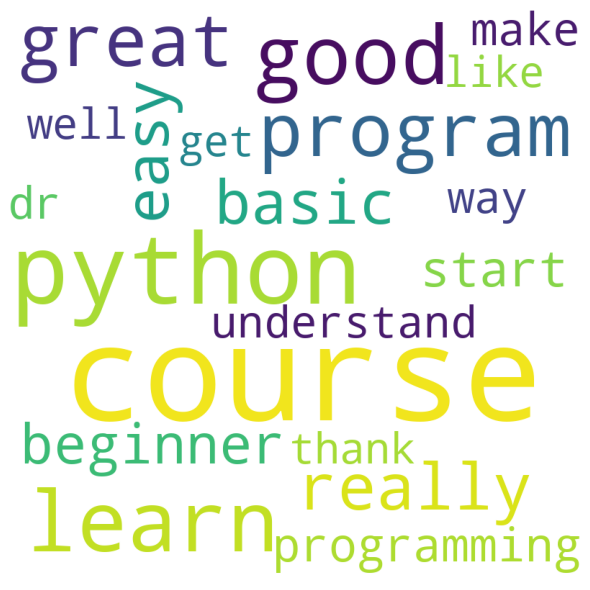

In [12]:
# Get unigram
lst = top_n_grams(df_python1['reviews_processed'],1,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

{'dr chuck': 1115, 'learn python': 1094, 'great course': 844, 'good course': 779, 'easy understand': 644, 'course beginner': 620, 'basic python': 515, 'charles severance': 447, 'excellent course': 432, 'course really': 415, 'programming language': 409, 'highly recommend': 387, 'look forward': 380, 'want learn': 379, 'really good': 369, 'take course': 366, 'python course': 363, 'start python': 361, 'recommend course': 357, 'learn basic': 353}


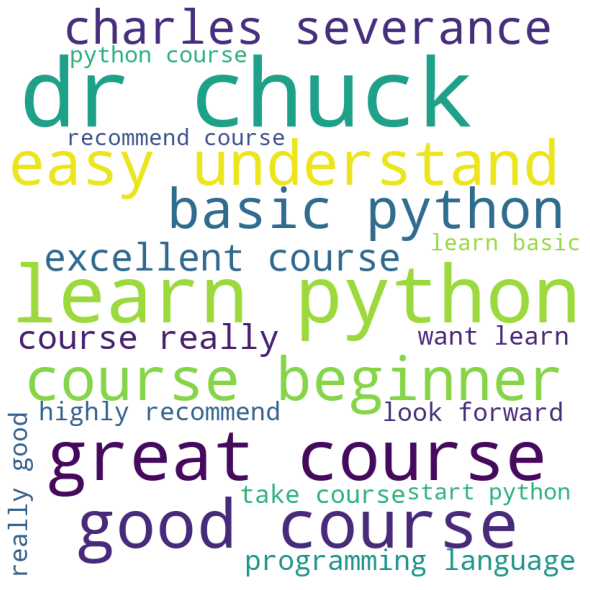

In [13]:
# Get bigram
lst = top_n_grams(df_python1['reviews_processed'],2,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

In [15]:
for key, value in lst.items():
    print(key, ' : ', value)

dr chuck  :  1115
learn python  :  1094
great course  :  844
good course  :  779
easy understand  :  644
course beginner  :  620
basic python  :  515
charles severance  :  447
excellent course  :  432
course really  :  415
programming language  :  409
highly recommend  :  387
look forward  :  380
want learn  :  379
really good  :  369
take course  :  366
python course  :  363
start python  :  361
recommend course  :  357
learn basic  :  353


{'want learn python': 187, 'learn basic python': 184, 'get start python': 167, 'start learn python': 145, 'good course beginner': 135, 'dr charles severance': 124, 'highly recommend course': 116, 'really enjoy course': 109, 'charles russell severance': 95, 'course dr chuck': 93, 'great course beginner': 93, 'look forward next': 87, 'thank dr chuck': 85, 'great introduction python': 81, 'really good course': 79, 'python programming language': 79, 'one best course': 77, 'thanks dr chuck': 75, 'recommend course anyone': 74, 'excellent course beginner': 71}


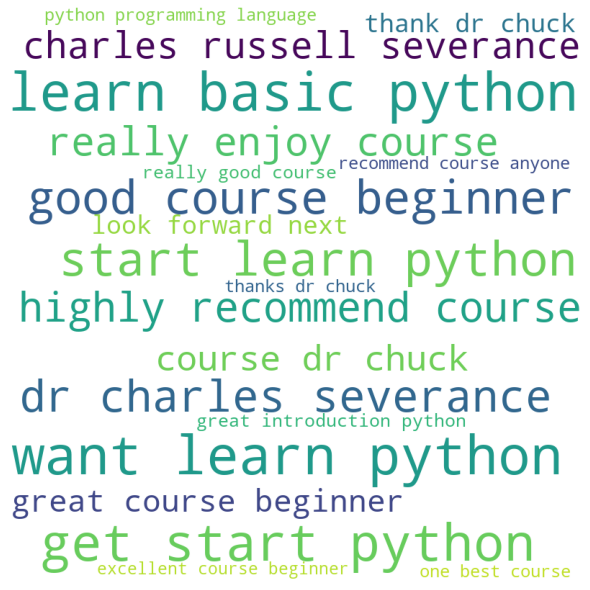

In [25]:
# Get trigram
lst = top_n_grams(df_python1['reviews_processed'],3,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

In [26]:
for key, value in lst.items():
    print(key, ' : ', value)

want learn python  :  187
learn basic python  :  184
get start python  :  167
start learn python  :  145
good course beginner  :  135
dr charles severance  :  124
highly recommend course  :  116
really enjoy course  :  109
charles russell severance  :  95
course dr chuck  :  93
great course beginner  :  93
look forward next  :  87
thank dr chuck  :  85
great introduction python  :  81
really good course  :  79
python programming language  :  79
one best course  :  77
thanks dr chuck  :  75
recommend course anyone  :  74
excellent course beginner  :  71


# Course 2 - "python-data"

In [16]:
df_python2 = df[df['course_id']=='python-data']

{'course': 7366, 'python': 2744, 'great': 2382, 'learn': 2132, 'good': 2104, 'chuck': 1387, 'dr': 1360, 'really': 1346, 'data': 1178, 'structure': 1129, 'easy': 919, 'excellent': 885, 'thank': 820, 'well': 783, 'best': 765, 'assignment': 732, 'lot': 725, 'way': 707, 'instructor': 685, 'understand': 684}


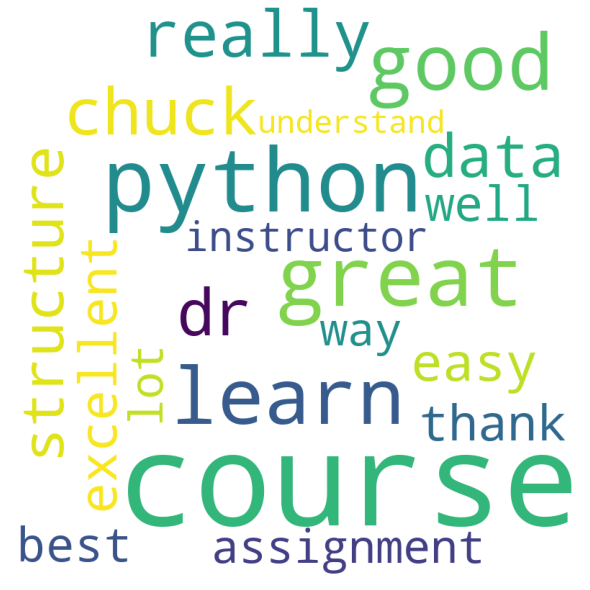

In [17]:
# Get unigram
lst = top_n_grams(df_python2['reviews_processed'],1,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

{'dr chuck': 1111, 'data structure': 975, 'great course': 964, 'good course': 528, 'learn python': 439, 'python data': 400, 'excellent course': 363, 'learn lot': 330, 'easy understand': 268, 'course learn': 253, 'course beginner': 225, 'best course': 220, 'course python': 202, 'nice course': 201, 'structure python': 201, 'awesome course': 191, 'love course': 186, 'course really': 164, 'python course': 156, 'course dr': 151}


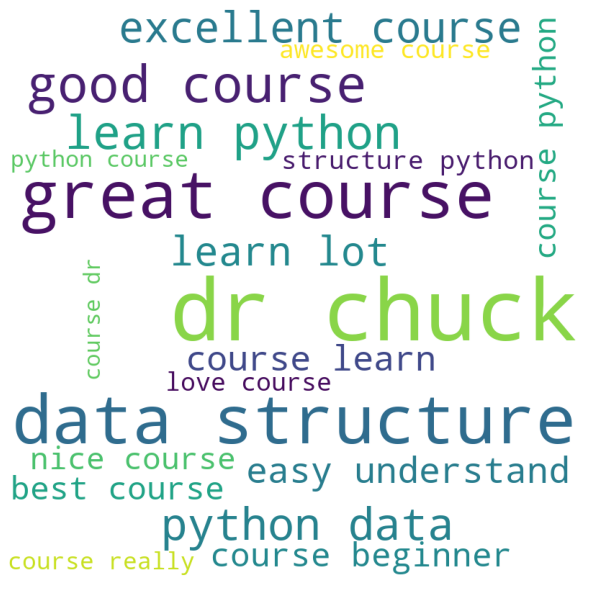

In [18]:
# Get bigram
lst = top_n_grams(df_python2['reviews_processed'],2,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

In [20]:
for key, value in lst.items():
    print(key, ' : ', value)

dr chuck  :  1111
data structure  :  975
great course  :  964
good course  :  528
learn python  :  439
python data  :  400
excellent course  :  363
learn lot  :  330
easy understand  :  268
course learn  :  253
course beginner  :  225
best course  :  220
course python  :  202
nice course  :  201
structure python  :  201
awesome course  :  191
love course  :  186
course really  :  164
python course  :  156
course dr  :  151


{'python data structure': 371, 'data structure python': 192, 'course dr chuck': 132, 'thank dr chuck': 93, 'dr chuck great': 81, 'thanks dr chuck': 77, 'learn python data': 71, 'learn data structure': 67, 'course learn lot': 64, 'good course beginner': 61, 'basic data structure': 59, 'one best course': 58, 'course learn python': 58, 'great course learn': 58, 'learn lot course': 55, 'want learn python': 55, 'list dictionary tuples': 50, 'dr charles severance': 49, 'get start python': 47, 'dr chuck awesome': 46}


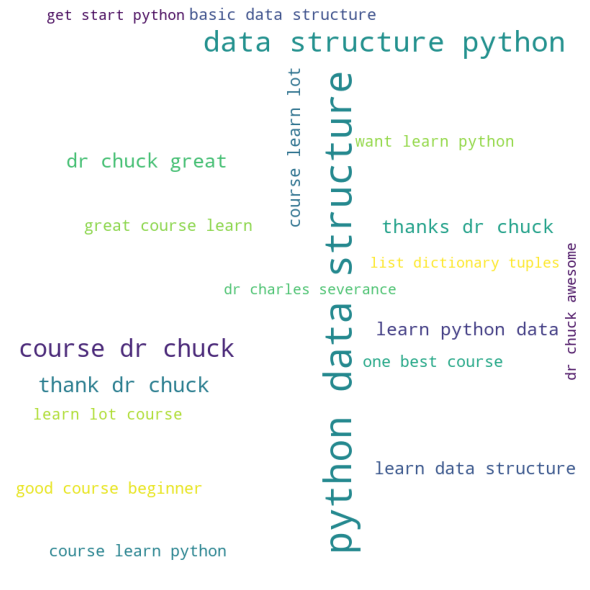

In [27]:
# Get trigram
lst = top_n_grams(df_python2['reviews_processed'],3,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

In [28]:
for key, value in lst.items():
    print(key, ' : ', value)

python data structure  :  371
data structure python  :  192
course dr chuck  :  132
thank dr chuck  :  93
dr chuck great  :  81
thanks dr chuck  :  77
learn python data  :  71
learn data structure  :  67
course learn lot  :  64
good course beginner  :  61
basic data structure  :  59
one best course  :  58
course learn python  :  58
great course learn  :  58
learn lot course  :  55
want learn python  :  55
list dictionary tuples  :  50
dr charles severance  :  49
get start python  :  47
dr chuck awesome  :  46


# Course 3 - "python-data-analysis"

In [21]:
df_python3 = df[df['course_id']=='python-data-analysis']

{'course': 4130, 'assignment': 2013, 'good': 1468, 'data': 1267, 'learn': 1190, 'python': 1158, 'great': 891, 'lot': 809, 'science': 687, 'really': 667, 'time': 642, 'lecture': 595, 'would': 498, 'panda': 497, 'get': 494, 'use': 491, 'video': 477, 'material': 428, 'well': 419, 'like': 413}


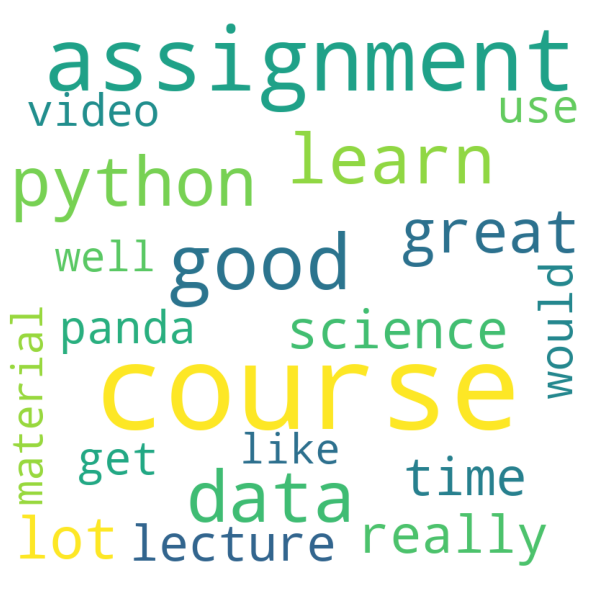

In [22]:
# Get unigram
lst = top_n_grams(df_python3['reviews_processed'],1,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

{'data science': 676, 'great course': 316, 'good course': 296, 'learn lot': 241, 'course learn': 118, 'excellent course': 118, 'discussion forum': 109, 'course really': 107, 'course good': 106, 'python data': 102, 'take course': 99, 'use python': 97, 'data analysis': 96, 'course material': 95, 'science python': 95, 'really good': 92, 'course assignment': 89, 'complete assignment': 81, 'nice course': 81, 'lot time': 78}


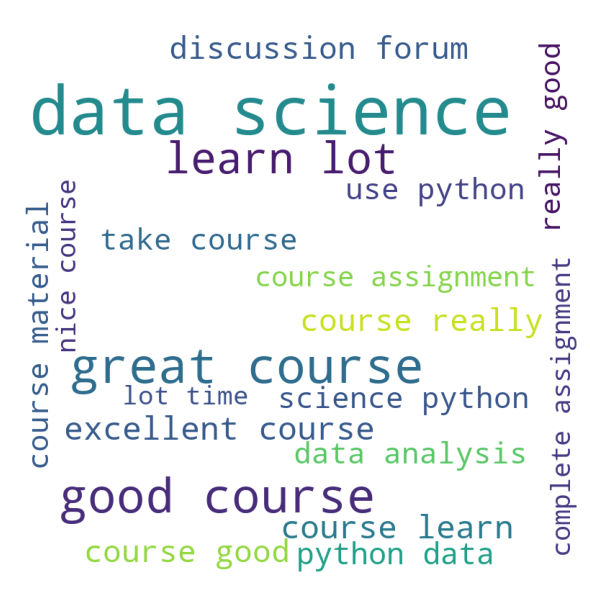

In [23]:
# Get bigram
lst = top_n_grams(df_python3['reviews_processed'],2,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

In [24]:
for key, value in lst.items():
    print(key, ' : ', value)

data science  :  676
great course  :  316
good course  :  296
learn lot  :  241
course learn  :  118
excellent course  :  118
discussion forum  :  109
course really  :  107
course good  :  106
python data  :  102
take course  :  99
use python  :  97
data analysis  :  96
course material  :  95
science python  :  95
really good  :  92
course assignment  :  89
complete assignment  :  81
nice course  :  81
lot time  :  78


{'data science python': 95, 'python data science': 68, 'introduction data science': 60, 'learn data science': 55, 'course data science': 40, 'learn lot course': 34, 'course learn lot': 34, 'start data science': 34, 'spend lot time': 33, 'data science course': 29, 'one best course': 25, 'basic data science': 24, 'good course learn': 23, 'data science use': 23, 'python data analysis': 22, 'great course learn': 22, 'really good course': 22, 'use python data': 21, 'science use python': 21, 'field data science': 19}


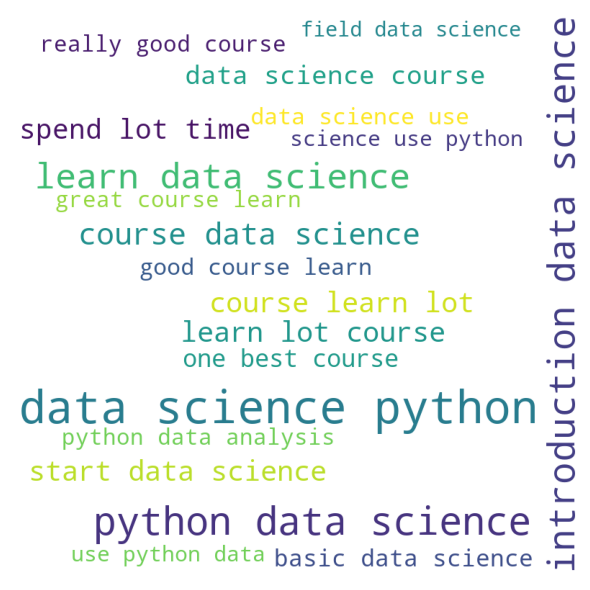

In [29]:
# Get trigram
lst = top_n_grams(df_python3['reviews_processed'],3,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

In [30]:
for key, value in lst.items():
    print(key, ' : ', value)

data science python  :  95
python data science  :  68
introduction data science  :  60
learn data science  :  55
course data science  :  40
learn lot course  :  34
course learn lot  :  34
start data science  :  34
spend lot time  :  33
data science course  :  29
one best course  :  25
basic data science  :  24
good course learn  :  23
data science use  :  23
python data analysis  :  22
great course learn  :  22
really good course  :  22
use python data  :  21
science use python  :  21
field data science  :  19


# ----- Sentiment Analysis

# Vader

In [9]:
sid = SentimentIntensityAnalyzer()
sa = df.copy()
sa['vader_scores'] = sa['reviews_processed_with_stopwords'].apply(lambda x: sid.polarity_scores(x))
sa['vader_polarity']  = sa['vader_scores'].apply(lambda score_dict: score_dict['compound'])
sa['vader_predict'] = sa['vader_polarity'].apply(lambda c: 'positive' if c >=0 else 'negative')

# Course 1 - "python"

In [10]:
sa_python1 = sa[sa['course_id']=='python']

<AxesSubplot:xlabel='vader_polarity'>

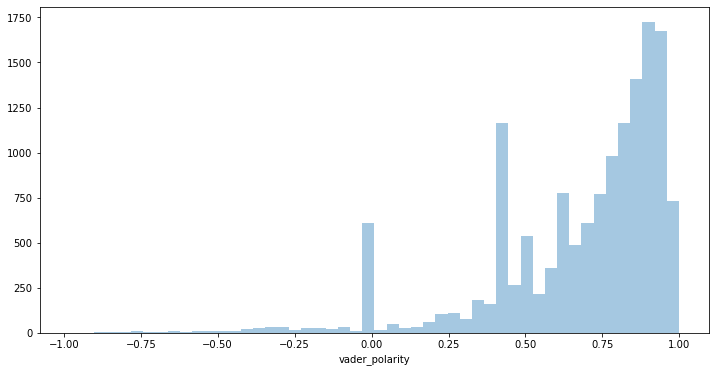

In [11]:
# Polarity histogram
plt.figure(figsize=(12,6))
sns.distplot(sa_python1['vader_polarity'].dropna(),hist=True ,kde=False)

{'learn python': 14, 'want learn': 10, 'dr chuck': 10, 'complete course': 9, 'good course': 9, 'course beginner': 8, 'course good': 8, 'last assignment': 8, 'python course': 8, 'basic python': 8, 'would recommend': 7, 'recommend course': 7, 'waste time': 7, 'great course': 7, 'blah blah': 7, 'prior knowledge': 6, 'learn program': 6, 'little bit': 6, 'really good': 6, 'look forward': 6}


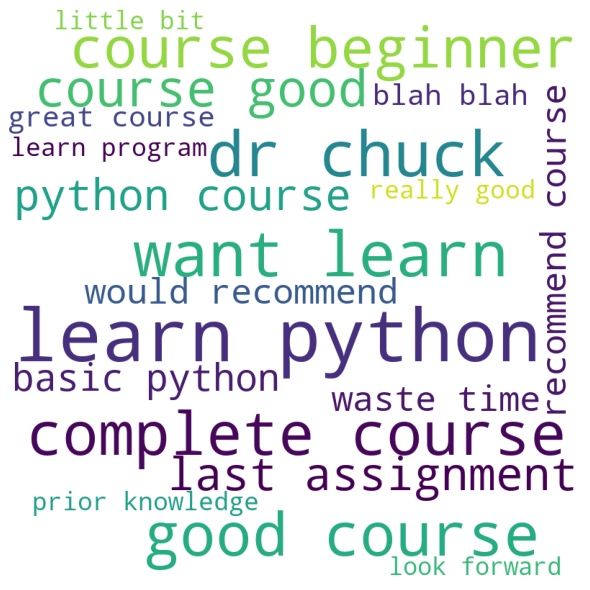

In [20]:
# Get bigram of negative
lst = top_n_grams(sa_python1[sa_python1['vader_polarity'] < 0]['reviews_processed'],2,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

{'dr chuck': 1105, 'learn python': 1080, 'great course': 837, 'good course': 770, 'easy understand': 641, 'course beginner': 612, 'basic python': 507, 'charles severance': 444, 'excellent course': 431, 'course really': 411, 'programming language': 404, 'highly recommend': 386, 'look forward': 374, 'want learn': 369, 'really good': 363, 'take course': 362, 'start python': 358, 'python course': 355, 'recommend course': 350, 'learn lot': 349}


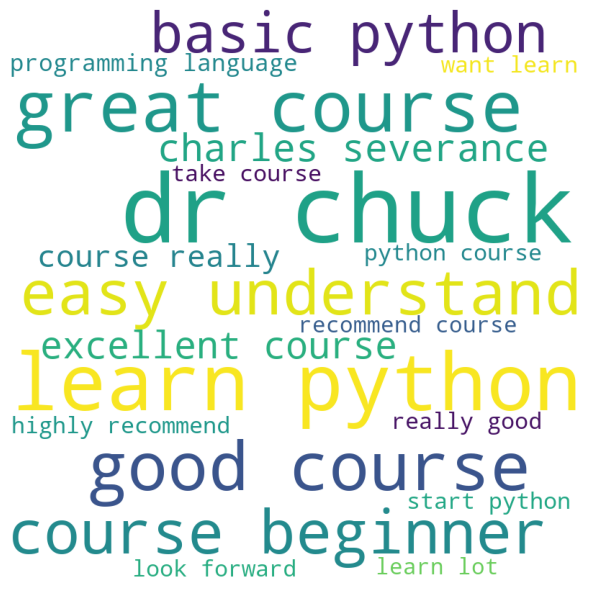

In [232]:
# Get bigram of positive
lst = top_n_grams(sa_python1[sa_python1['vader_polarity'] >= 0]['reviews_processed'],2,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

# Course 2 - "python-data"

In [22]:
sa_python2 = sa[sa['course_id']=='python-data']

<AxesSubplot:xlabel='vader_polarity'>

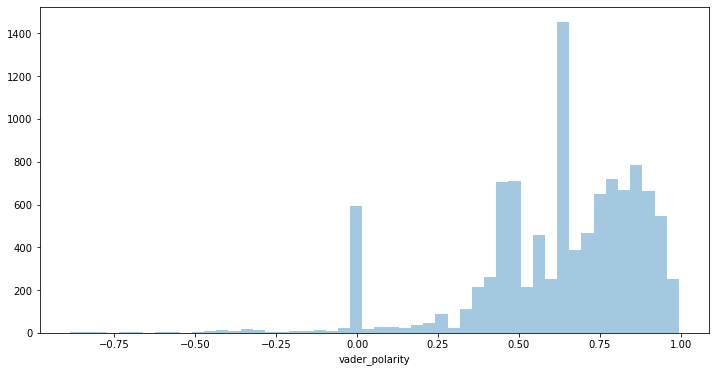

In [23]:
# Polarity histogram
plt.figure(figsize=(12,6))
sns.distplot(sa_python2['vader_polarity'].dropna(),hist=True ,kde=False)

{'data structure': 13, 'first course': 6, 'bit difficult': 5, 'little bit': 5, 'course teach': 4, 'great course': 4, 'good course': 4, 'learn lot': 4, 'bit tough': 4, 'complete assignment': 4, 'course good': 3, 'course material': 3, 'solve problem': 3, 'assignment problem': 3, 'well explain': 3, 'teach basic': 3, 'data set': 3, 'unnecessary talk': 2, 'computer science': 2, 'concept really': 2}


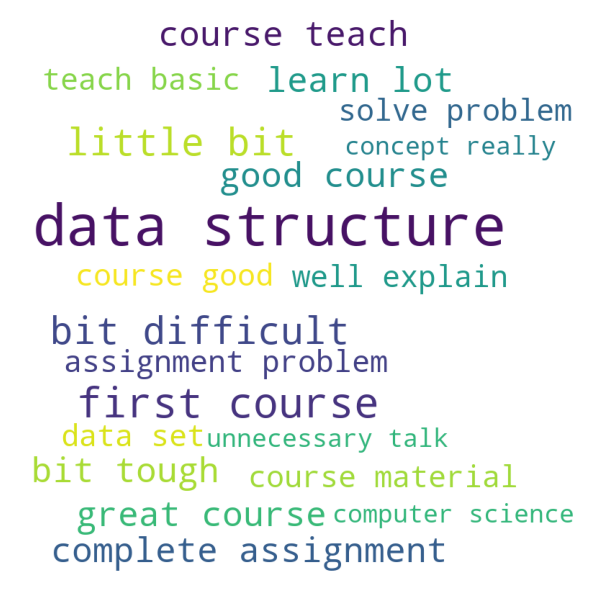

In [24]:
# Get bigram of negative
lst = top_n_grams(sa_python2[sa_python2['vader_polarity'] < 0]['reviews_processed'],2,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

{'dr chuck': 1105, 'learn python': 1080, 'great course': 837, 'good course': 770, 'easy understand': 641, 'course beginner': 612, 'basic python': 507, 'charles severance': 444, 'excellent course': 431, 'course really': 411, 'programming language': 404, 'highly recommend': 386, 'look forward': 374, 'want learn': 369, 'really good': 363, 'take course': 362, 'start python': 358, 'python course': 355, 'recommend course': 350, 'learn lot': 349}


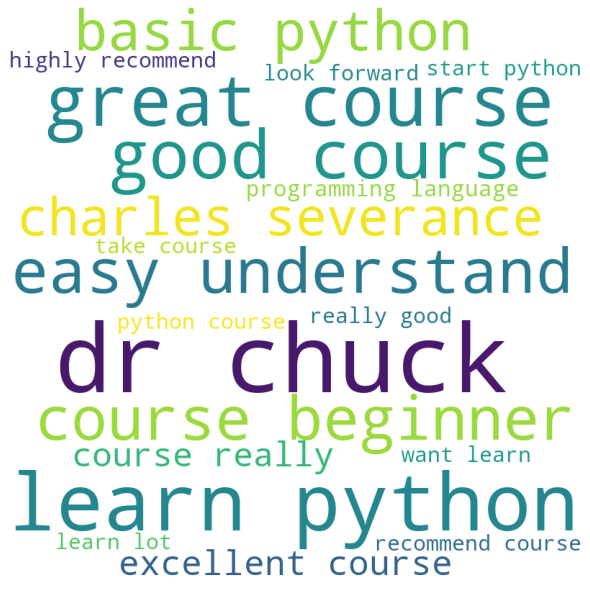

In [236]:
# Get bigram of positive
lst = top_n_grams(sa_python1[sa_python1['vader_polarity'] >= 0]['reviews_processed'],2,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

# Course 3 - "python-data-analysis"

In [26]:
sa_python3 = sa[sa['course_id']=='python-data-analysis']

<AxesSubplot:xlabel='vader_polarity'>

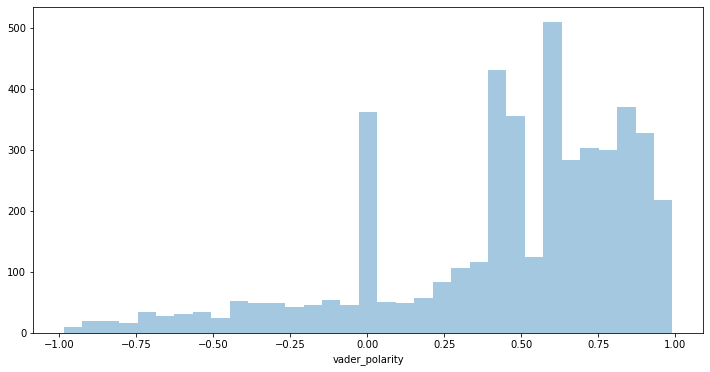

In [27]:
# Polarity histogram
plt.figure(figsize=(12,6))
sns.distplot(sa_python3['vader_polarity'].dropna(),hist=True ,kde=False)

{'data science': 47, 'learn lot': 24, 'stack overflow': 18, 'course content': 18, 'course material': 17, 'discussion forum': 17, 'complete assignment': 17, 'good course': 17, 'lot time': 16, 'take course': 16, 'assignment question': 16, 'bad course': 14, 'auto grader': 14, 'waste time': 13, 'assignment really': 13, 'assignment difficult': 12, 'complete course': 12, 'course assignment': 12, 'video lecture': 12, 'course good': 12}


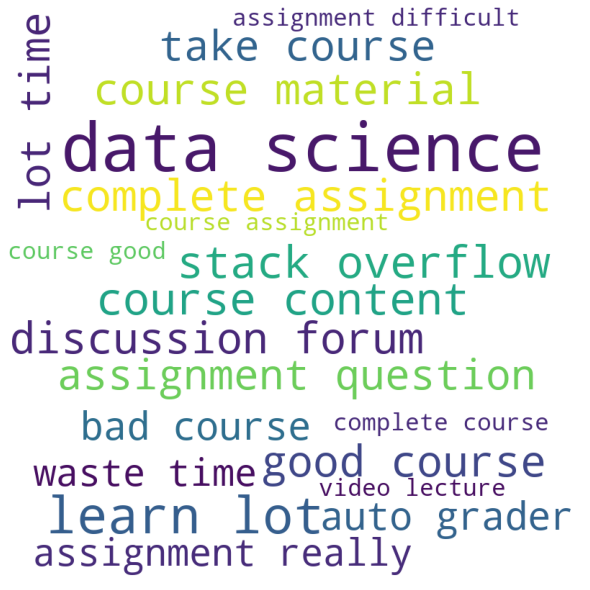

In [28]:
# Get bigram of negative
lst = top_n_grams(sa_python3[sa_python3['vader_polarity'] < 0]['reviews_processed'],2,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

{'data science': 629, 'great course': 312, 'good course': 279, 'learn lot': 217, 'excellent course': 117, 'course learn': 111, 'python data': 96, 'course really': 96, 'course good': 94, 'use python': 93, 'discussion forum': 92, 'science python': 91, 'data analysis': 88, 'really good': 88, 'take course': 83, 'course material': 78, 'nice course': 78, 'course assignment': 77, 'learn data': 67, 'learn python': 65}


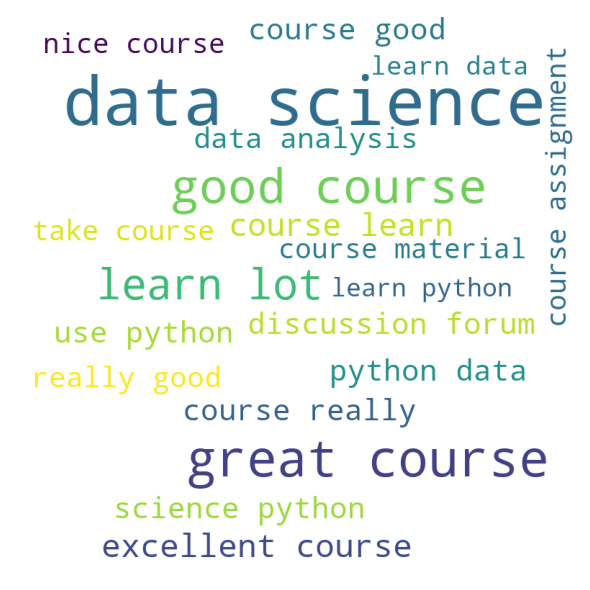

In [240]:
# Get bigram of positive
lst = top_n_grams(sa_python3[sa_python3['vader_polarity'] >= 0]['reviews_processed'],2,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

# Textblob

In [30]:
sa['textblob_polarity'] = sa['reviews_processed_with_stopwords'].apply(lambda x: TextBlob(x).sentiment[0])
sa['textblob_predict'] = sa['textblob_polarity'].apply(lambda c: 'positive' if c >=0 else 'negative')

# Course 1 - "python"

In [243]:
sa_python1 = sa[sa['course_id']=='python']

<AxesSubplot:xlabel='textblob_polarity'>

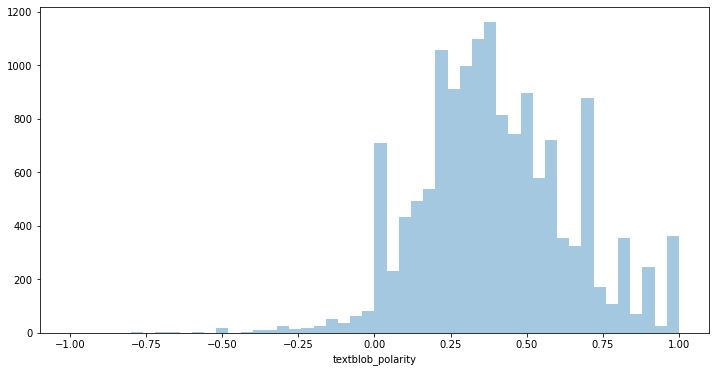

In [244]:
# Polarity histogram
plt.figure(figsize=(12,6))
sns.distplot(sa_python1['textblob_polarity'].dropna(),hist=True ,kde=False)

{'dr chuck': 25, 'learn python': 21, 'little bit': 16, 'programming language': 15, 'course beginner': 9, 'take course': 8, 'learn basic': 8, 'learn lot': 8, 'university michigan': 7, 'last assignment': 7, 'python course': 7, 'want learn': 7, 'course help': 7, 'look forward': 7, 'bit difficult': 7, 'program course': 6, 'bit slow': 6, 'slow pace': 6, 'little knowledge': 6, 'little slow': 6}


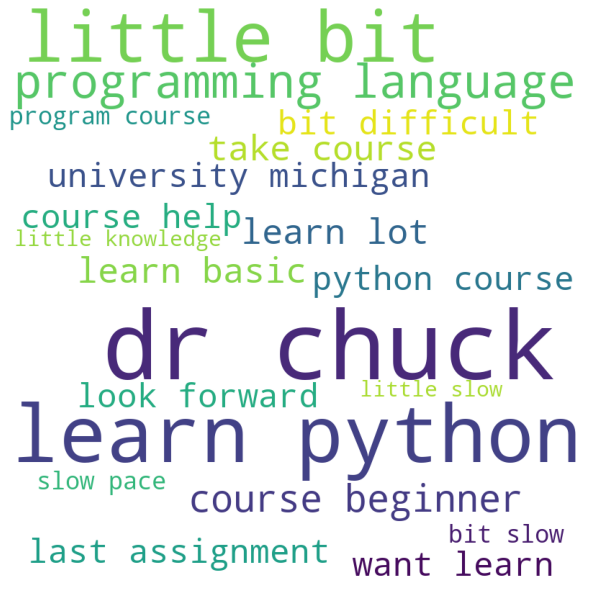

In [245]:
# Get bigram of negative
lst = top_n_grams(sa_python1[sa_python1['textblob_polarity'] < 0]['reviews_processed'],2,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

{'dr chuck': 1090, 'learn python': 1073, 'great course': 843, 'good course': 774, 'easy understand': 643, 'course beginner': 611, 'basic python': 509, 'charles severance': 444, 'excellent course': 432, 'course really': 410, 'programming language': 394, 'highly recommend': 384, 'look forward': 373, 'want learn': 372, 'really good': 368, 'take course': 358, 'python course': 356, 'start python': 356, 'recommend course': 352, 'learn basic': 345}


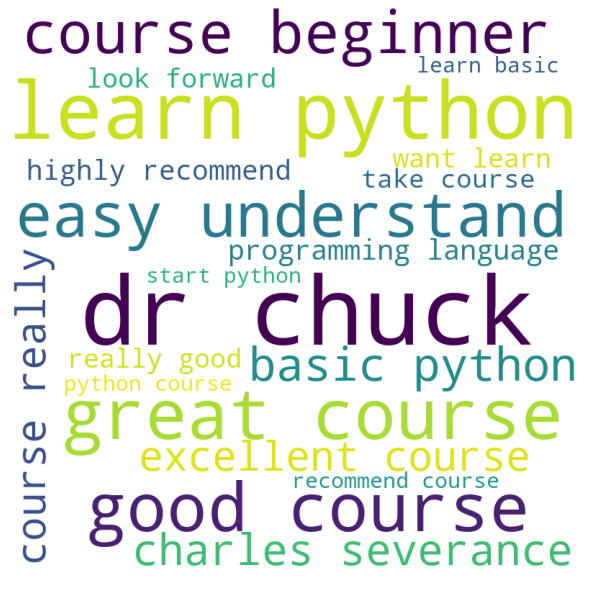

In [246]:
# Get bigram of positive
lst = top_n_grams(sa_python1[sa_python1['textblob_polarity'] >= 0]['reviews_processed'],2,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

# Course 2 - "python-data"

In [247]:
sa_python2 = sa[sa['course_id']=='python-data']

<AxesSubplot:xlabel='textblob_polarity'>

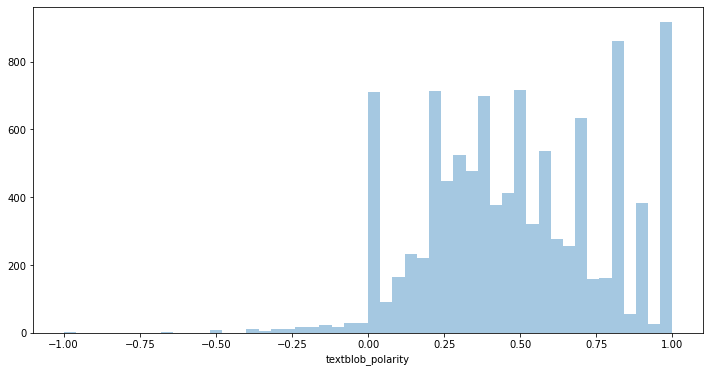

In [248]:
# Polarity histogram
plt.figure(figsize=(12,6))
sns.distplot(sa_python2['textblob_polarity'].dropna(),hist=True ,kde=False)

{'data structure': 21, 'dr chuck': 16, 'little bit': 10, 'bit tough': 8, 'learn lot': 7, 'learn python': 6, 'previous course': 5, 'previous one': 5, 'bit difficult': 4, 'course help': 4, 'course thank': 4, 'really helpful': 4, 'complete assignment': 3, 'recommend course': 3, 'bit slow': 3, 'dictionary tuples': 3, 'use list': 3, 'well taught': 3, 'tuples dictionary': 3, 'compare previous': 3}


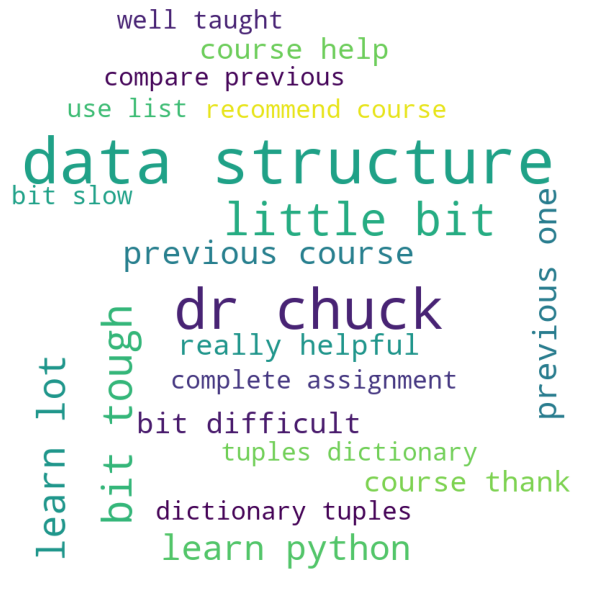

In [249]:
# Get bigram of negative
lst = top_n_grams(sa_python2[sa_python2['textblob_polarity'] < 0]['reviews_processed'],2,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

{'dr chuck': 1095, 'great course': 961, 'data structure': 954, 'good course': 528, 'learn python': 433, 'python data': 398, 'excellent course': 362, 'learn lot': 323, 'easy understand': 267, 'course learn': 250, 'course beginner': 222, 'best course': 220, 'nice course': 201, 'course python': 200, 'structure python': 200, 'awesome course': 191, 'love course': 186, 'course really': 161, 'python course': 154, 'thank much': 151}


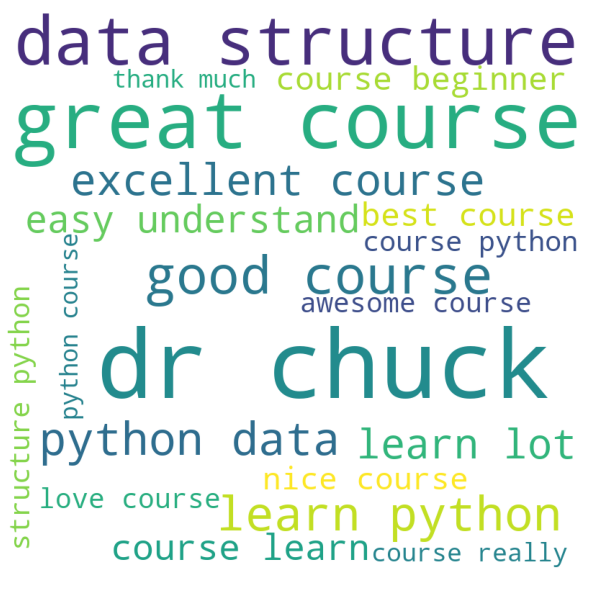

In [250]:
# Get bigram of positive
lst = top_n_grams(sa_python2[sa_python2['textblob_polarity'] >= 0]['reviews_processed'],2,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

# Course 3 - "python-data-analysis"

In [251]:
sa_python3= sa[sa['course_id']=='python-data-analysis']

<AxesSubplot:xlabel='textblob_polarity'>

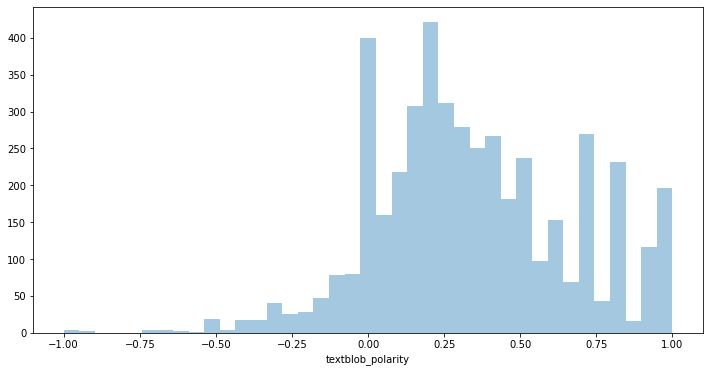

In [252]:
# Polarity histogram
plt.figure(figsize=(12,6))
sns.distplot(sa_python3['textblob_polarity'].dropna(),hist=True ,kde=False)

{'data science': 31, 'learn lot': 20, 'little bit': 14, 'lot time': 13, 'course content': 12, 'bad course': 12, 'assignment question': 12, 'course material': 11, 'discussion forum': 11, 'complete assignment': 11, 'assignment hard': 11, 'complete course': 10, 'stack overflow': 10, 'learn python': 10, 'assignment tough': 10, 'bit difficult': 10, 'jupyter notebook': 9, 'python panda': 8, 'much time': 7, 'assignment way': 7}


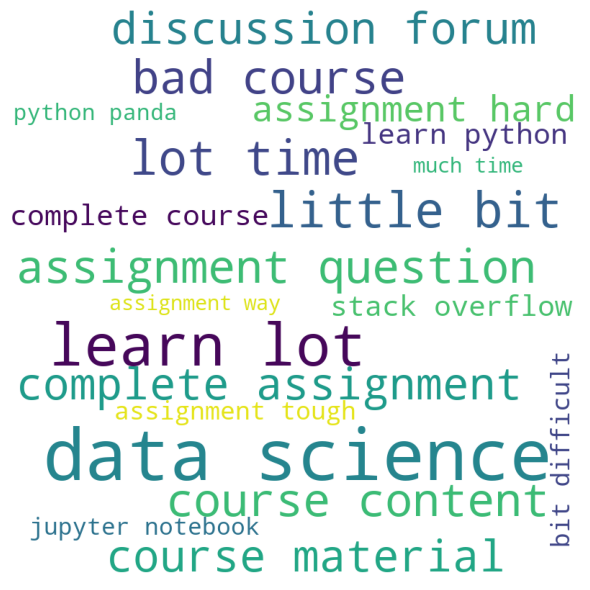

In [253]:
# Get bigram of negative
lst = top_n_grams(sa_python3[sa_python3['textblob_polarity'] < 0]['reviews_processed'],2,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

{'data science': 645, 'great course': 313, 'good course': 292, 'learn lot': 221, 'excellent course': 118, 'course learn': 112, 'course good': 102, 'course really': 100, 'python data': 98, 'discussion forum': 98, 'science python': 95, 'use python': 93, 'data analysis': 92, 'take course': 92, 'really good': 92, 'course material': 84, 'course assignment': 82, 'nice course': 80, 'complete assignment': 70, 'learn data': 69}


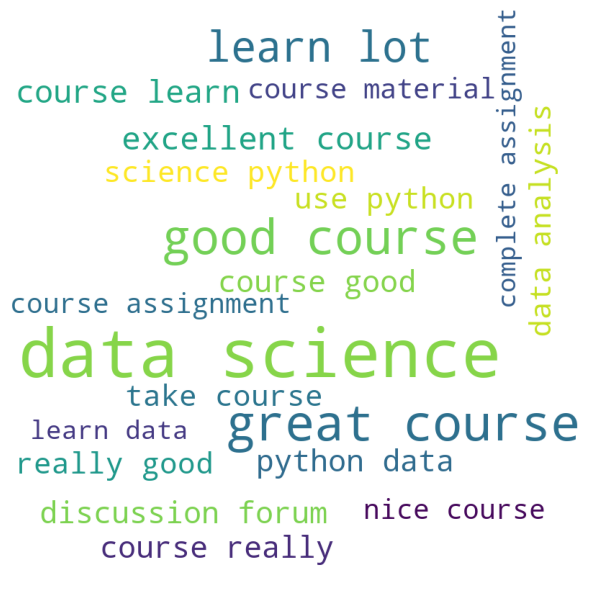

In [254]:
# Get bigram of positive
lst = top_n_grams(sa_python3[sa_python3['textblob_polarity'] >= 0]['reviews_processed'],2,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

# Overall Polarity

In [35]:
# get overall polarity using avergar of textblob and vader
sa['mean_polarity'] = (sa['vader_polarity'] + sa['textblob_polarity'])/2
sa['mean_predict'] = sa['mean_predict'] = sa['mean_polarity'].apply(lambda c: 'positive' if c >=0 else 'negative')
sa

course_id                                            reviews  rating  \
0        python  I did not find this course helpful. The assign...       1   
1        python  I got a 95% and maybe I learned something but ...       1   
2        python  Two weeks of all sort of nonsense, including m...       1   
3        python  We tried to use this class to teach a brown ba...       1   
4        python  To be honest, I thought the course stumbled an...       1   
...         ...                                                ...     ...   
29809    python  This course is so good. I can easily understan...       5   
29810    python  Excellent and in-depth explanation of each and...       5   
29811    python  Love it! Even though it isn't my first python ...       5   
29812    python  Really good introduction to python! This progr...       5   
29813    python  This is my first coursera course which i have ...       5   

       reviews_length language  \
0               476.0       en   
1               376.0       en   
2               375.0       en   
3               335.0       en   
4              1328.0       en   
...               ...      ...   
29809            93.0       en   
29810            93.0       en   
29811            92.0       en   
29812            92.0       en   
29813            92.0       en   

                                       reviews_processed  \
0      find course helpful assignment seem ask info t...   
1      get 95 maybe learn something honestly say watc...   
2      two week sort nonsense include macarena harry ...   
3      try use class teach brown bag lunch employee i...   
4      honest think course stumble fell short basic s...   
...                                                  ...   
29809  course good easily understand basic python pro...   
29810  excellent indepth explanation every topic look...   
29811  love even though first python course ive learn...   
29812  really good introduction python program break ...   
29813  first coursera course complete successfullydr ...   

                        reviews_processed_with_stopwords     label  \
0      i do not find this course helpful the assignme...  negative   
1      i get a 95 and maybe i learn something but i c...  negative   
2      two week of all sort of nonsense include macar...  negative   
3      we try to use this class to teach a brown bag ...  negative   
4      to be honest i think the course stumble and fe...  negative   
...                                                  ...       ...   
29809  this course be so good i can easily understand...  positive   
29810  excellent and indepth explanation of each and ...  positive   
29811  love it even though it be not my first python ...  positive   
29812  really good introduction to python this progra...  positive   
29813  this be my first coursera course which i have ...  positive   

                                            vader_scores  vader_polarity  \
0      {'neg': 0.073, 'neu': 0.871, 'pos': 0.056, 'co...         -0.1700   
1      {'neg': 0.072, 'neu': 0.847, 'pos': 0.081, 'co...          0.1531   
2      {'neg': 0.258, 'neu': 0.707, 'pos': 0.035, 'co...         -0.9146   
3      {'neg': 0.051, 'neu': 0.849, 'pos': 0.1, 'comp...          0.2289   
4      {'neg': 0.094, 'neu': 0.792, 'pos': 0.114, 'co...          0.6265   
...                                                  ...             ...   
29809  {'neg': 0.0, 'neu': 0.67, 'pos': 0.33, 'compou...          0.7510   
29810  {'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'comp...          0.5719   
29811  {'neg': 0.0, 'neu': 0.802, 'pos': 0.198, 'comp...          0.6369   
29812  {'neg': 0.0, 'neu': 0.641, 'pos': 0.359, 'comp...          0.8070   
29813  {'neg': 0.0, 'neu': 0.774, 'pos': 0.226, 'comp...          0.5423   

      vader_predict  textblob_polarity textblob_predict  mean_polarity  \
0          negative           0.500000         positive       0.165000   
1          positive           0.00416

# Course 1 - "python"

<AxesSubplot:xlabel='mean_polarity'>

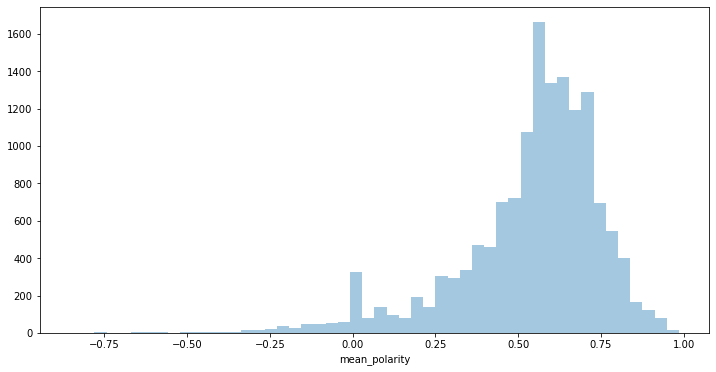

In [36]:
sa_python1 = sa[sa['course_id']=='python']

# Polarity histogram
plt.figure(figsize=(12,6))
sns.distplot(sa_python1['mean_polarity'].dropna(),hist=True ,kde=False)

{'learn python': 13, 'waste time': 8, 'basic python': 8, 'dr chuck': 8, 'last assignment': 7, 'little bit': 7, 'complete course': 6, 'learn basic': 6, 'python course': 6, 'want learn': 6, 'look forward': 6, 'course beginner': 5, 'course would': 5, 'course good': 5, 'good course': 5, 'bit difficult': 5, 'basic course': 5, 'course python': 5, 'program course': 4, 'course course': 4}


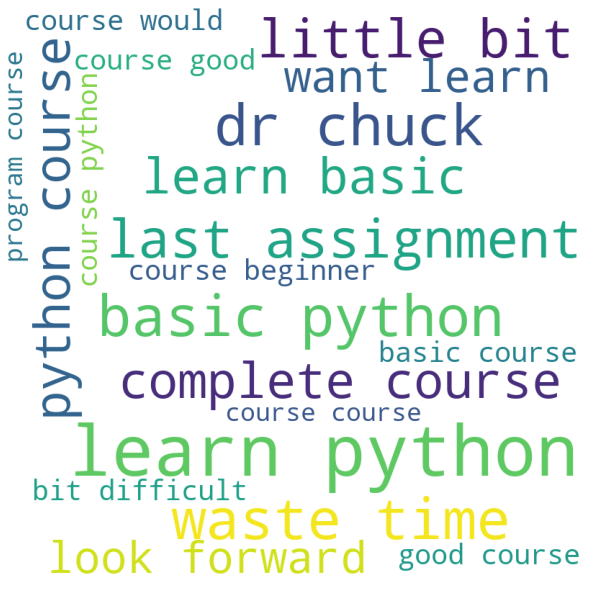

In [37]:
# Get bigram of negative
lst = top_n_grams(sa_python1[sa_python1['mean_polarity'] < 0]['reviews_processed'],2,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

{'dr chuck': 1107, 'learn python': 1081, 'great course': 840, 'good course': 774, 'easy understand': 642, 'course beginner': 615, 'basic python': 507, 'charles severance': 444, 'excellent course': 431, 'course really': 412, 'programming language': 405, 'highly recommend': 386, 'look forward': 374, 'want learn': 373, 'really good': 366, 'take course': 362, 'start python': 359, 'python course': 357, 'recommend course': 354, 'learn basic': 347}


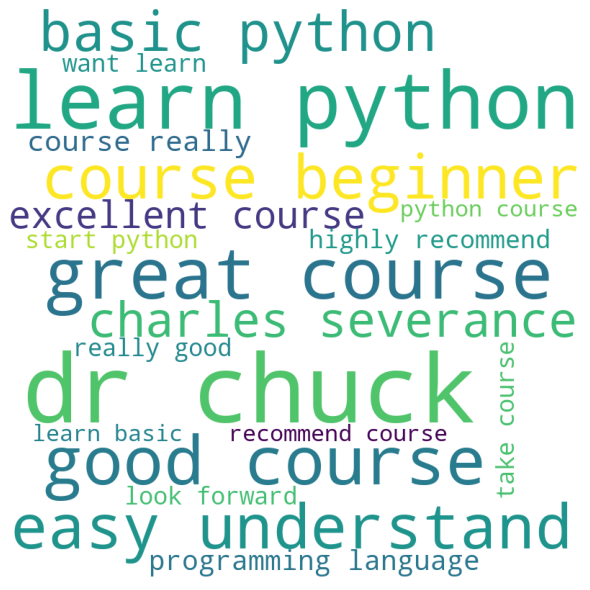

In [48]:
# Get bigram of positive
lst = top_n_grams(sa_python1[sa_python1['mean_polarity'] >= 0]['reviews_processed'],2,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

{'apply financial aid': 3, 'learn basic python': 3, 'want learn python': 3, 'run wrong program': 2, 'waste time learn': 2, 'keep give indentation': 2, 'course would helpful': 2, 'last assignment work': 2, 'take long time': 2, 'long time figure': 2, 'want learn program': 2, 'basic python program': 2, 'write basic code': 2, 'need get start': 2, 'course completely change': 2, 'get start python': 2, 'great course teacher': 2, 'course teacher know': 2, 'teacher know material': 2, 'know material lot': 2}


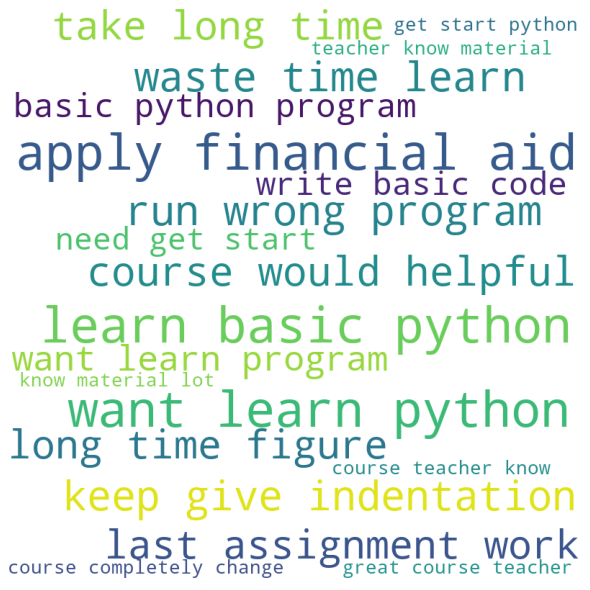

In [38]:
# Get trigram of negative
lst = top_n_grams(sa_python1[sa_python1['mean_polarity'] < 0]['reviews_processed'],3,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

{'want learn python': 184, 'learn basic python': 181, 'get start python': 165, 'start learn python': 144, 'good course beginner': 135, 'dr charles severance': 123, 'highly recommend course': 116, 'really enjoy course': 109, 'charles russell severance': 95, 'course dr chuck': 93, 'great course beginner': 93, 'look forward next': 87, 'thank dr chuck': 85, 'great introduction python': 81, 'really good course': 79, 'python programming language': 79, 'one best course': 77, 'thanks dr chuck': 75, 'recommend course anyone': 73, 'excellent course beginner': 71}


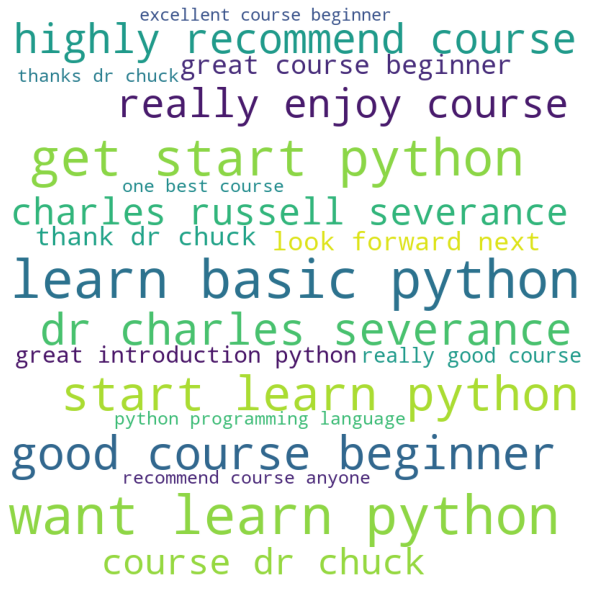

In [49]:
# Get trigram of positive
lst = top_n_grams(sa_python1[sa_python1['mean_polarity'] >= 0]['reviews_processed'],3,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

# Course 2 - "python-data"

<AxesSubplot:xlabel='mean_polarity'>

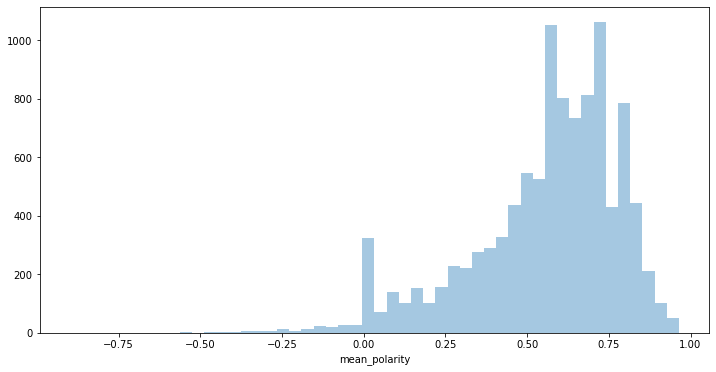

In [41]:
sa_python2 = sa[sa['course_id']=='python-data']

# Polarity histogram
plt.figure(figsize=(12,6))
sns.distplot(sa_python2['mean_polarity'].dropna(),hist=True ,kde=False)

{'data structure': 13, 'little bit': 7, 'complete assignment': 5, 'learn lot': 5, 'bit tough': 5, 'dr chuck': 4, 'first course': 4, 'bit difficult': 4, 'data type': 3, 'previous course': 3, 'great course': 3, 'course material': 3, 'course bit': 3, 'solve problem': 3, 'new thing': 3, 'well explain': 3, 'python programming': 3, 'data set': 3, 'previous one': 3, 'unnecessary talk': 2}


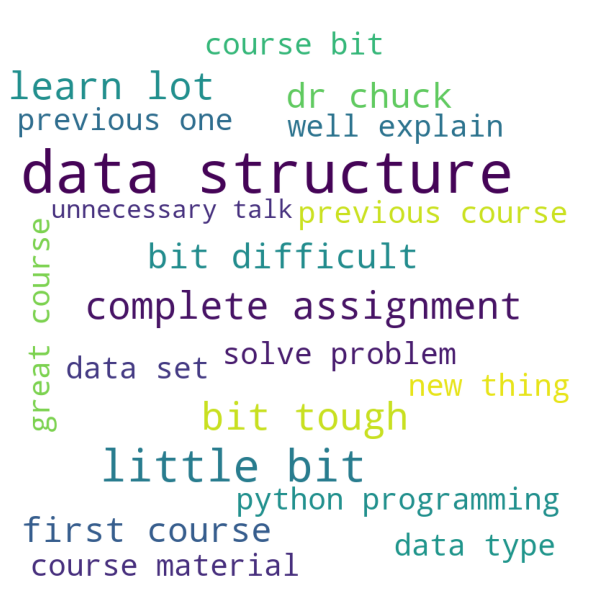

In [42]:
# Get bigram of negative
lst = top_n_grams(sa_python2[sa_python2['mean_polarity'] < 0]['reviews_processed'],2,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

{'dr chuck': 1107, 'data structure': 962, 'great course': 961, 'good course': 526, 'learn python': 437, 'python data': 398, 'excellent course': 362, 'learn lot': 325, 'easy understand': 268, 'course learn': 253, 'course beginner': 224, 'best course': 220, 'nice course': 201, 'course python': 200, 'structure python': 199, 'awesome course': 191, 'love course': 185, 'course really': 164, 'python course': 154, 'course dr': 151}


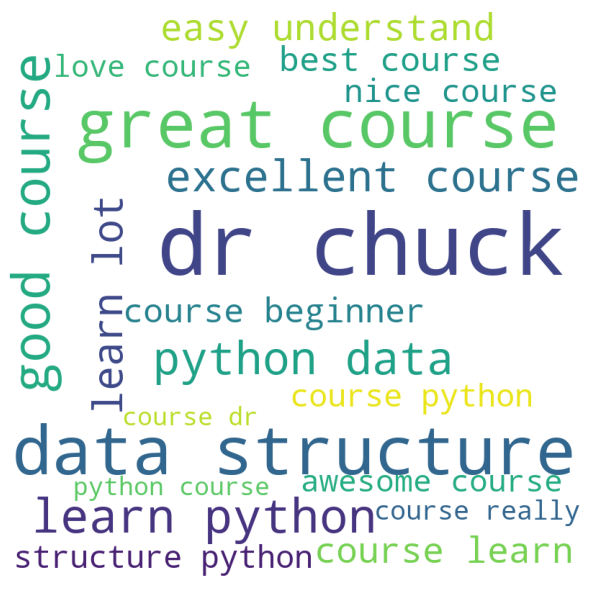

In [50]:
# Get bigram of positive
lst = top_n_grams(sa_python2[sa_python2['mean_polarity'] >= 0]['reviews_processed'],2,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

{'much irrelevant information': 2, 'great course give': 2, 'data structure course': 2, 'data structure python': 2, 'python data structure': 2, 'little bit tough': 2, 'bit tough previous': 2, 'tough previous one': 2, 'teaching guy talk': 1, 'guy talk problem': 1, 'talk problem set': 1, 'problem set practice': 1, 'set practice need': 1, 'practice need help': 1, 'need help pause': 1, 'help pause video': 1, 'pause video try': 1, 'video try code': 1, 'try code seriously': 1, 'code seriously though': 1}


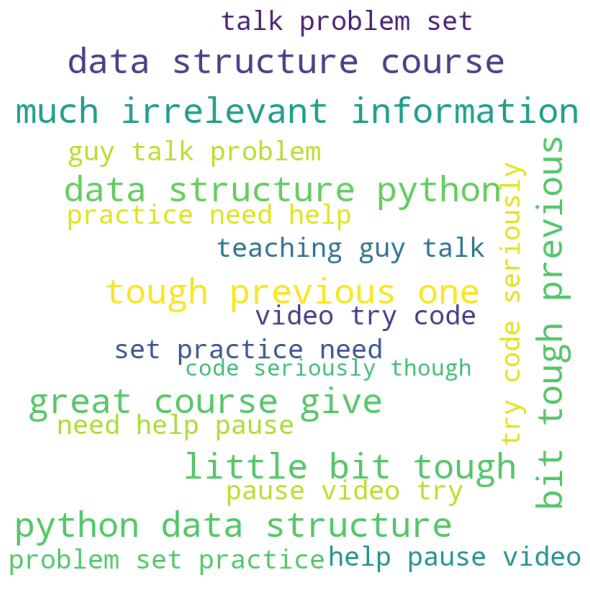

In [44]:
# Get trigram of negative
lst = top_n_grams(sa_python2[sa_python2['mean_polarity'] < 0]['reviews_processed'],3,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

{'python data structure': 369, 'data structure python': 190, 'course dr chuck': 132, 'thank dr chuck': 93, 'dr chuck great': 81, 'thanks dr chuck': 77, 'learn python data': 71, 'learn data structure': 67, 'course learn lot': 64, 'good course beginner': 61, 'one best course': 58, 'basic data structure': 58, 'course learn python': 58, 'great course learn': 58, 'learn lot course': 55, 'want learn python': 55, 'list dictionary tuples': 49, 'dr charles severance': 49, 'get start python': 46, 'dr chuck awesome': 46}


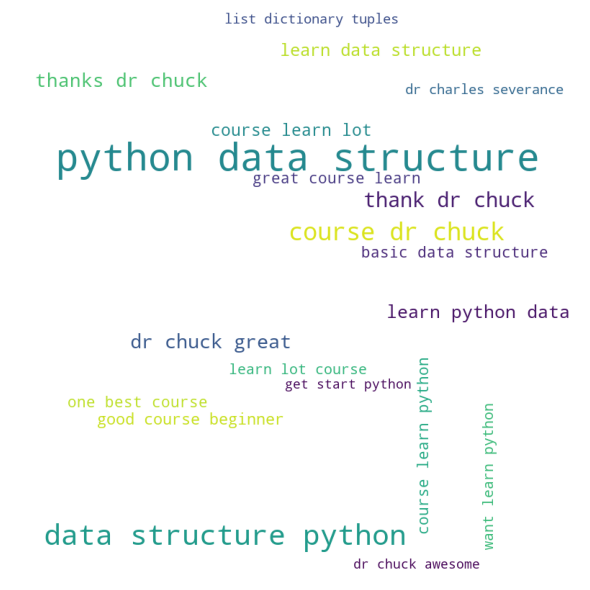

In [51]:
# Get trigram of positive
lst = top_n_grams(sa_python2[sa_python2['mean_polarity'] >= 0]['reviews_processed'],3,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

# Course 3 - "python-data-analysis"

<AxesSubplot:xlabel='mean_polarity'>

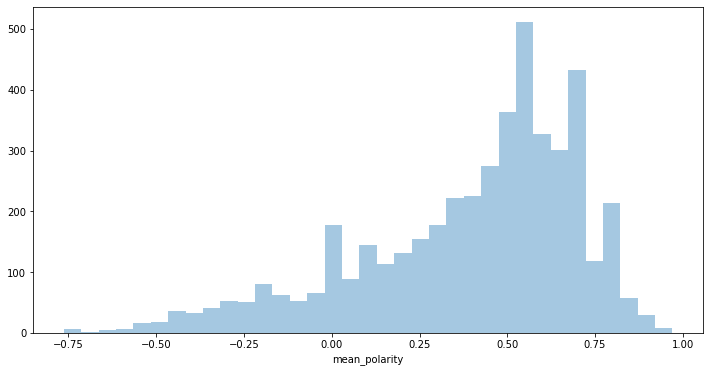

In [45]:
sa_python3 = sa[sa['course_id']=='python-data-analysis']

# Polarity histogram
plt.figure(figsize=(12,6))
sns.distplot(sa_python3['mean_polarity'].dropna(),hist=True ,kde=False)

{'data science': 44, 'learn lot': 24, 'stack overflow': 18, 'complete assignment': 17, 'lot time': 16, 'discussion forum': 16, 'good course': 16, 'course content': 16, 'course material': 15, 'bad course': 15, 'take course': 14, 'course assignment': 13, 'waste time': 12, 'assignment really': 12, 'version panda': 12, 'auto grader': 12, 'complete course': 12, 'assignment difficult': 11, 'course really': 11, 'video lecture': 11}


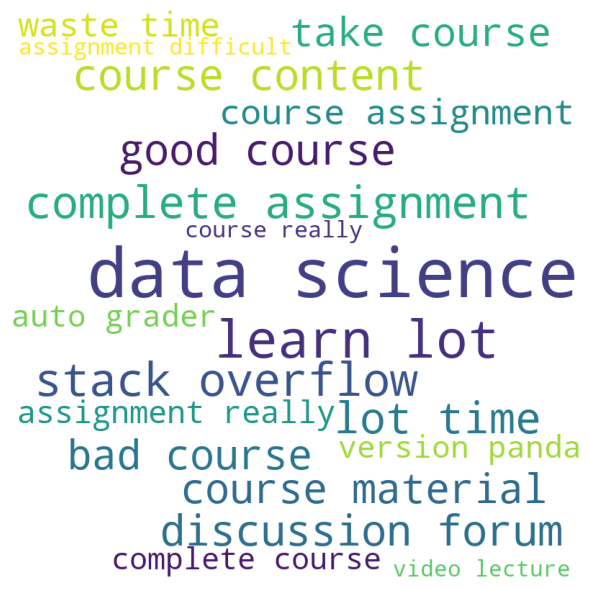

In [46]:
# Get bigram of negative
lst = top_n_grams(sa_python3[sa_python3['mean_polarity'] < 0]['reviews_processed'],2,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

{'data science': 632, 'great course': 314, 'good course': 280, 'learn lot': 217, 'excellent course': 117, 'course learn': 112, 'course good': 98, 'course really': 96, 'python data': 95, 'science python': 93, 'use python': 93, 'discussion forum': 93, 'data analysis': 90, 'really good': 88, 'take course': 85, 'course material': 80, 'nice course': 79, 'course assignment': 76, 'learn data': 68, 'course great': 66}


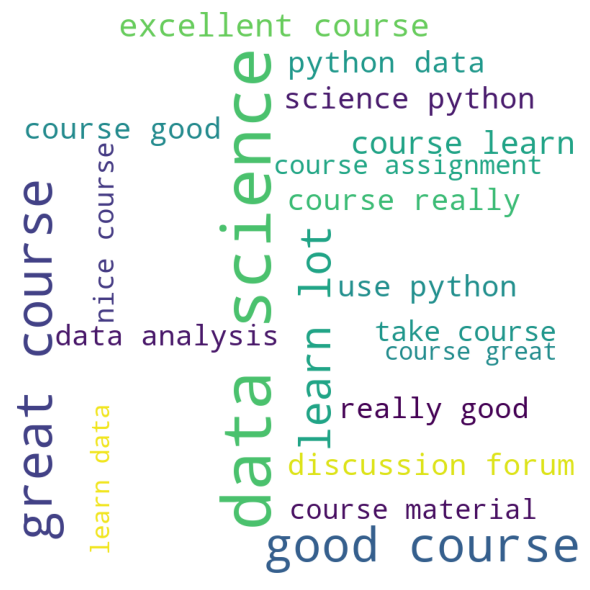

In [52]:
# Get bigram of positive
lst = top_n_grams(sa_python3[sa_python3['mean_polarity'] >= 0]['reviews_processed'],2,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

{'spend lot time': 7, 'introduction data science': 7, 'would recommend course': 6, 'outdated version panda': 6, 'bad course ever': 6, 'data science course': 5, 'python data science': 5, 'read discussion forum': 4, 'waste much time': 3, 'course really really': 3, 'waste time money': 3, 'course much good': 3, 'take much long': 3, 'ever take coursera': 3, 'real world problem': 3, 'assignment grade system': 3, 'watch youtube video': 3, 'machine learn course': 3, 'assignment really difficult': 3, 'assume know everything': 3}


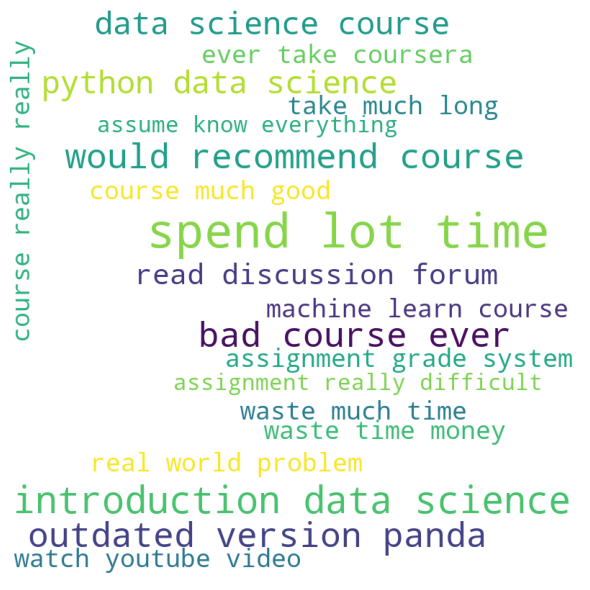

In [47]:
# Get trigram of negative
lst = top_n_grams(sa_python3[sa_python3['mean_polarity'] < 0]['reviews_processed'],3,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

{'data science python': 93, 'python data science': 63, 'learn data science': 54, 'introduction data science': 53, 'course data science': 39, 'start data science': 34, 'learn lot course': 33, 'course learn lot': 32, 'spend lot time': 26, 'one best course': 25, 'data science course': 24, 'basic data science': 24, 'good course learn': 23, 'data science use': 23, 'great course learn': 22, 'really good course': 22, 'science use python': 21, 'python data analysis': 20, 'use python data': 19, 'really enjoy course': 19}


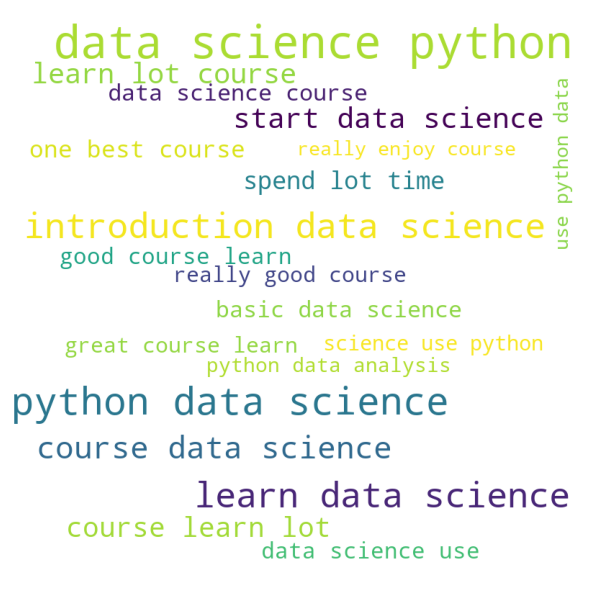

In [53]:
# Get trigram of positive
lst = top_n_grams(sa_python3[sa_python3['mean_polarity'] >= 0]['reviews_processed'],3,20)
print(lst)
wordcloud= WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(lst)
  
# plot the WordCloud image                        
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

# Evaluate Performance

In [33]:
# All course
# Report the confusion matrix of Vader
data = sa.copy()
print(metrics.confusion_matrix(data['label'],data['vader_predict']))

# Print a classification report Vader
print(metrics.classification_report(data['label'],data['vader_predict']))

# Report the confusion matrix of Textblob
print(metrics.confusion_matrix(data['label'],data['textblob_predict']))

# Print a classification report Textblob
print(metrics.classification_report(data['label'],data['textblob_predict']))

# Report the confusion matrix of mean
print(metrics.confusion_matrix(data['label'],data['mean_predict']))

# Print a classification report mean
print(metrics.classification_report(data['label'],data['mean_predict']))

[[  304   407]
 [  809 28287]]
              precision    recall  f1-score   support

    negative       0.27      0.43      0.33       711
    positive       0.99      0.97      0.98     29096

    accuracy                           0.96     29807
   macro avg       0.63      0.70      0.66     29807
weighted avg       0.97      0.96      0.96     29807

[[  236   475]
 [  757 28339]]
              precision    recall  f1-score   support

    negative       0.24      0.33      0.28       711
    positive       0.98      0.97      0.98     29096

    accuracy                           0.96     29807
   macro avg       0.61      0.65      0.63     29807
weighted avg       0.97      0.96      0.96     29807

[[  326   385]
 [  772 28324]]
              precision    recall  f1-score   support

    negative       0.30      0.46      0.36       711
    positive       0.99      0.97      0.98     29096

    accuracy                           0.96     29807
   macro avg       0.64      0.72  

In [202]:
sa

course_id                                            reviews  rating  \
0        python  I did not find this course helpful. The assign...       1   
1        python  I got a 95% and maybe I learned something but ...       1   
2        python  Two weeks of all sort of nonsense, including m...       1   
3        python  We tried to use this class to teach a brown ba...       1   
4        python  To be honest, I thought the course stumbled an...       1   
...         ...                                                ...     ...   
29809    python  This course is so good. I can easily understan...       5   
29810    python  Excellent and in-depth explanation of each and...       5   
29811    python  Love it! Even though it isn't my first python ...       5   
29812    python  Really good introduction to python! This progr...       5   
29813    python  This is my first coursera course which i have ...       5   

       reviews_length language  \
0               476.0       en   
1               376.0       en   
2               375.0       en   
3               335.0       en   
4              1328.0       en   
...               ...      ...   
29809            93.0       en   
29810            93.0       en   
29811            92.0       en   
29812            92.0       en   
29813            92.0       en   

                                       reviews_processed     label  \
0      find course helpful assignment seem ask info t...  negative   
1      get ninefive maybe learn something honestly sa...  negative   
2      two week sort nonsense include macarena harry ...  negative   
3      try use class teach brown bag lunch employee i...  negative   
4      honest think course stumble fell short basic s...  negative   
...                                                  ...       ...   
29809  course good easily understand basic python pro...  positive   
29810  excellent indepth explanation every topic look...  positive   
29811  love even though first python course ive learn...  positive   
29812  really good introduction python program break ...  positive   
29813  first coursera course complete successfullydr ...  positive   

                        reviews_processed_with_stopwords  \
0      i do not find this course helpful the assignme...   
1      i get a ninefive and maybe i learn something b...   
2      two week of all sort of nonsense include macar...   
3      we try to use this class to teach a brown bag ...   
4      to be honest i think the course stumble and fe...   
...                                                  ...   
29809  this course be so good i can easily understand...   
29810  excellent and indepth explanation of each and ...   
29811  love it even though it be not my first python ...   
29812  really good introduction to python this progra...   
29813  this be my first coursera course which i have ...   

                                            vader_scores  vader_polarity  \
0      {'neg': 0.073, 'neu': 0.871, 'pos': 0.056, 'co...         -0.1700   
1      {'neg': 0.072, 'neu': 0.847, 'pos': 0.081, 'co...          0.1531   
2      {'neg': 0.23, 'neu': 0.708, 'pos': 0.061, 'com...         -0.8805   
3      {'neg': 0.051, 'neu': 0.849, 'pos': 0.1, 'comp...          0.2289   
4      {'neg': 0.093, 'neu': 0.793, 'pos': 0.114, 'co...          0.6265   
...                                                  ...             ...   
29809  {'neg': 0.0, 'neu': 0.67, 'pos': 0.33, 'compou...          0.7510   
29810  {'neg': 0.0, 'neu': 0.778, 'pos': 0.222, 'comp...          0.5719   
29811  {'neg': 0.0, 'neu': 0.802, 'pos': 0.198, 'comp...          0.6369   
29812  {'neg': 0.0, 'neu': 0.641, 'pos': 0.359, 'comp...          0.8070   
29813  {'neg': 0.0, 'neu': 0.774, 'pos': 0.226, 'comp...          0.5423   

      vader_predict  textblob_polarity textblob_predict  
0          negative           0.500000         positive  
1          positive           0.004167         positive  
2          

In [34]:
sa.to_csv('final_table.csv',index=False)